In [ ]:
!pip install datasets

# **Importing Neccessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from scipy.sparse import csr_matrix
import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from datasets import load_dataset
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# **Load the SST dataset**

In [ ]:
sst_dataset = load_dataset("sst",trust_remote_code=True)

# Print dataset information
print(sst_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['sentence', 'label', 'tokens', 'tree'],
        num_rows: 2210
    })
})


In [ ]:
#extract train, validation and test data
train = sst_dataset['train']
val = sst_dataset['validation']
test = sst_dataset['test']

This function map_sentiment(score) categorizes sentiment scores into five distinct classes based on predefined score ranges. Scores from 0 to 0.2 are mapped to class 0 ("very negative"), scores from 0.2 to 0.4 to class 1 ("negative"), scores from 0.4 to 0.6 to class 2 ("neutral"), scores from 0.6 to 0.8 to class 3 ("positive"), and scores from 0.8 to 1.0 to class 4 ("very positive").

In [ ]:
# Map the scores to sentiment classes
def map_sentiment(score):
    mappingFn = {
        (0, 0.2): 0,
        (0.2, 0.4): 1,
        (0.4, 0.6): 2,
        (0.6, 0.8): 3,
        (0.8, 1.0): 4
    }

    for range_, category in mappingFn.items():
        if range_[0] <= score <= range_[1]:
            return category

In [ ]:
labels = train["label"]
train_labels = []
for label in labels:
  train_labels.append(map_sentiment(label))

In [ ]:
labels = val["label"]
val_labels = []
for label in labels:
  val_labels.append(map_sentiment(label))

In [ ]:
labels = test["label"]
test_labels = []
for label in labels:
  test_labels.append(map_sentiment(label))

# **Vectorizing Text Data for Bigram Features**
It extracts bigram features from the training data (X_train_def), applies the same transformation to the testing and validation data, and retrieves the names of the extracted bigram features. The resulting feature matrices (X_train, X_test, X_val) contain integer counts of word bigrams, enabling further analysis and model training.

In [ ]:
# tokenizing sentences bby spliting
def tokenize(sentence):
    return sentence.split()

# Get all possible bigrams from given sentence
def generateBigrams(sentence):
    words = tokenize(sentence)
    for i in range(len(words)-1):
        yield (words[i+1], words[i])  # Fixed the order of words

# Generating features for the training set
def trainFeatures(dataset):
    total_bigrams = set()
    for example in dataset:
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:  # Iterate over the yielded values
            total_bigrams.add(bi_gram)

    bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(total_bigrams)}

    features = np.zeros((len(dataset), len(total_bigrams)))

    for i, example in enumerate(dataset):
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:  # Iterate over the yielded values
            index = bi_gram_to_index.get(bi_gram)
            if index is not None:
                features[i, index] = 1

    return features, total_bigrams

# Generating features for validation and test sets
def nonTrainFeatures(dataset, total_bigrams):
    bi_gram_to_index = {bi_gram: index for index, bi_gram in enumerate(total_bigrams)}

    features = np.zeros((len(dataset), len(total_bigrams)))

    for i, example in enumerate(dataset):
        bigrams = generateBigrams(example['sentence'])
        for bi_gram in bigrams:
            index = bi_gram_to_index.get(bi_gram)
            if index is not None:
                features[i, index] = 1

    return features

In [ ]:
train_features, bigrams = trainFeatures(train)

In [ ]:
val_features = nonTrainFeatures(val, bigrams)
test_features = nonTrainFeatures(test, bigrams)
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

(8544, 87249)
(1101, 87249)
(2210, 87249)


In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

In [ ]:
# converting features from float32 to int16
train_features = np.array(train_features,dtype = np.int16)
val_features = np.array(val_features,dtype = np.int16)
test_features = np.array(test_features,dtype = np.int16)

# **Logistic Regression Classifier Implementation**
The fit method trains the model using stochastic gradient descent (SGD) by iterating over the data in mini-batches, updating the weights based on the calculated gradients.
The predict method computes class predictions using the learned weights and the sigmoid activation function.
The class allows for customization of hyperparameters such as learning rate, number of iterations, and batch size, offering flexibility in model training.

In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_epochs=100, batch_size=32):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.weights = None
        self.bias = None

    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)

    def fit(self, X, y):
      n_samples, n_features = X.shape
      n_classes = 5
      self.weights = np.random.randn(n_features, n_classes)
      self.bias = np.zeros(n_classes)
      for epoch in range(self.num_epochs):
          indices = np.random.permutation(len(X))
          X_shuffled = X[indices]
          y_shuffled = y[indices]

          for i in range(0, len(X), self.batch_size):
              batch_X = X_shuffled[i:i+self.batch_size]
              batch_y = y_shuffled[i:i+self.batch_size]

              logits = np.dot(batch_X, self.weights) + self.bias
              outputs = self.softmax(logits)

              one_hot_labels = np.eye(n_classes)[batch_y]

              gradient = outputs - one_hot_labels
              weight_gradient = np.dot(batch_X.T, gradient)
              bias_gradient = np.sum(gradient, axis=0)

              self.weights -= self.learning_rate * weight_gradient
              self.bias -= self.learning_rate * bias_gradient


    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        outputs = self.softmax(logits)
        return np.argmax(outputs, axis=1)

In [ ]:
model = LogisticRegression()
model.fit(train_features, train_labels)

# **Logistic Regression Model Comparison between Scikit-learn and Custom Implementation**

In [ ]:
# Initialize and train logistic regression model from scikit-learn
sklearn_logreg_model = LogisticRegression(max_iter=1000)
sklearn_logreg_model.fit(train_features, train_labels)

# Make predictions using scikit-learn model
sklearn_predictions = sklearn_logreg_model.predict(test_features)

# Calculate accuracy of scikit-learn model
sklearn_accuracy = accuracy_score(test_labels, sklearn_predictions)
print("Scikit-learn Logistic Regression Accuracy:", sklearn_accuracy)

# Calculate accuracy of custom implementation
custom_predictions = model.predict(test_features)
custom_accuracy = np.mean(custom_predictions == test_labels)
print("Custom Logistic Regression Accuracy:", custom_accuracy)


Scikit-learn Logistic Regression Accuracy: 0.35429864253393667
Custom Logistic Regression Accuracy: 0.2828054298642534


# **Confusion Matrix and Precision-Recall-F1 Score Calculation**

In [ ]:
def confusion_matrix(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        cm[true_label][pred_label] += 1

    return cm

def precision_recall_f1(cm):
    num_classes = len(cm)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)
        f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    return precision, recall, f1



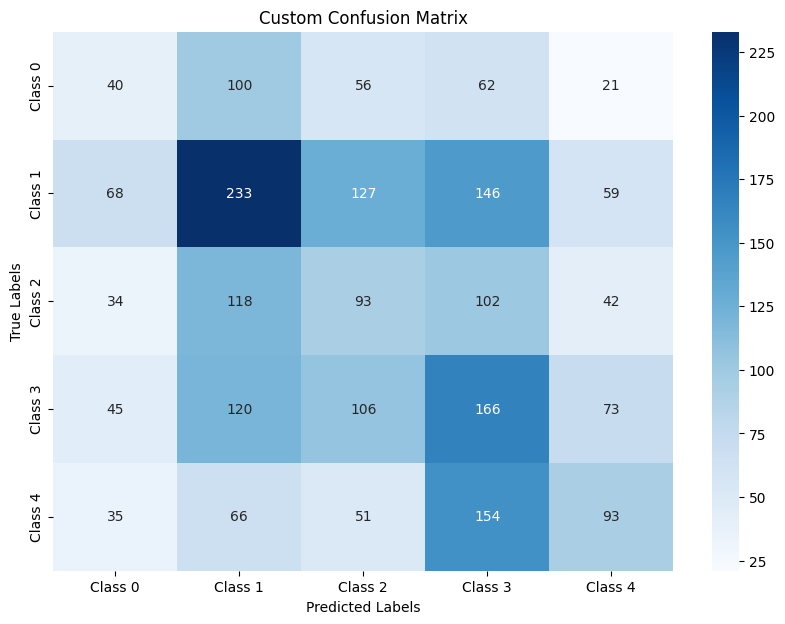

Custom Precision: [0.18018018 0.36577708 0.2147806  0.26349206 0.32291667]
Custom Recall: [0.14336918 0.36808847 0.23907455 0.3254902  0.23308271]
Custom F1 Score: [0.15968064 0.36692913 0.22627737 0.29122807 0.27074236]


In [ ]:
# Generate confusion matrix
custom_cm = confusion_matrix(test_labels, custom_predictions)

# Compute precision, recall, and F1 score
precision_custom, recall_custom, f1_custom = precision_recall_f1(custom_cm)

plt.figure(figsize=(10, 7))
sns.heatmap(custom_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Custom Confusion Matrix')
plt.show()
print("Custom Precision:", precision_custom)
print("Custom Recall:", recall_custom)
print("Custom F1 Score:", f1_custom)

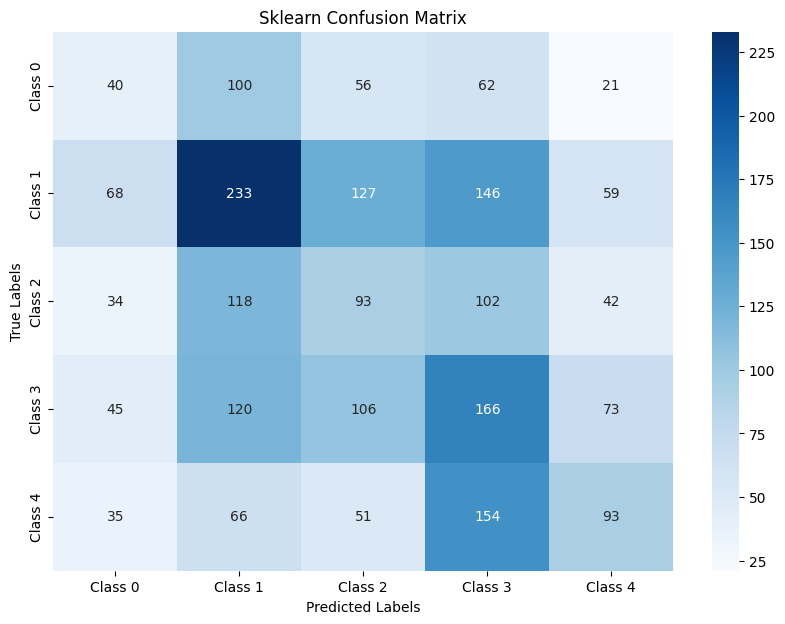

Scikit-learn Precision: [0.18018018 0.36577708 0.2147806  0.26349206 0.32291667]
Scikit-learn Recall: [0.14336918 0.36808847 0.23907455 0.3254902  0.23308271]
Scikit-learn F1 Score: [0.15968064 0.36692913 0.22627737 0.29122807 0.27074236]


In [ ]:
# Compute confusion matrix using scikit-learn
cm_sklearn = confusion_matrix(test_labels, custom_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Sklearn Confusion Matrix')
plt.show()

# Compute precision, recall, and F1 score using scikit-learn
precision_sklearn = precision_score(test_labels, custom_predictions, average=None)
recall_sklearn = recall_score(test_labels, custom_predictions, average=None)
f1_score_sklearn = f1_score(test_labels, custom_predictions, average=None)

print("Scikit-learn Precision:", precision_sklearn)
print("Scikit-learn Recall:", recall_sklearn)
print("Scikit-learn F1 Score:", f1_score_sklearn)


# **Naive Bayes Classifier Training and Testing**

In [ ]:
def train_naive_bayes(D, C):
    # Calculate P(c) terms
    Ndoc = len(D)
    logprior = np.zeros(len(C))
    bigdoc = {}

    for idx, c in enumerate(C):
        Nc = sum(1 for d in D if d[1] == c)
        logprior[idx] = np.log(Nc / Ndoc)

        bigdoc[c] = [d[0] for d in D if d[1] == c]

    # Create vocabulary V
    V = set()
    for doc in D:
        V.update(doc[0])
    V = list(V)

    # Calculate P(w/c) terms
    loglikelihood = np.zeros((len(V), len(C)))
    for idx, c in enumerate(C):
        Wc = bigdoc[c]
        for j, word in enumerate(V):
            count_wc = sum(1 for doc in Wc if word in doc)
            loglikelihood[j, idx] = np.log((count_wc + 1) / (len(V) + len(Wc)))

    return logprior, loglikelihood, V

def test_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    sum_ = np.zeros(len(C))
    for idx, c in enumerate(C):
        sum_[idx] = logprior[idx]

        for word in testdoc:
            if word in V:
                sum_[idx] += loglikelihood[V.index(word), idx]

    return np.argmax(sum_)


In [ ]:
# Load the training dataset
train_data = [(d['tokens'].split('|'), d['label']) for d in train]

# Train Naive Bayes classifier
logprior, loglikelihood, V = train_naive_bayes(train_data, [0, 1, 2, 3, 4])

# Test Naive Bayes classifier on validation data
correct = 0
total = len(val)
for instance in val:
    predicted_class = test_naive_bayes(instance['tokens'].split('|'), logprior, loglikelihood, [0, 1, 2, 3, 4], V)
    if predicted_class == int(round(instance['label'] * 4)):
        correct += 1

accuracy = correct / total
print("Validation Accuracy:", accuracy)

# Test Naive Bayes classifier on test data
correct = 0
total = len(test)
for instance in test:
    predicted_class = test_naive_bayes(instance['tokens'].split('|'), logprior, loglikelihood, [0, 1, 2, 3, 4], V)
    if predicted_class == int(round(instance['label'] * 4)):
        correct += 1

accuracy = correct / total
print("Test Accuracy:", accuracy)

TypeError: string indices must be integers

In [ ]:
# Vectorize text data for Naive Bayes
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(train)
X_test_vec = vectorizer.transform(train)

# Train scikit-learn Naive Bayes classifier
sklearn_nb_model = MultinomialNB()
sklearn_nb_model.fit(X_train_vec, test_labels)

# Test scikit-learn Naive Bayes classifier
sklearn_nb_predictions = sklearn_nb_model.predict(X_test_vec)

# Calculate accuracy of scikit-learn Naive Bayes classifier
sklearn_nb_accuracy = np.mean(sklearn_nb_predictions == test_labels) * 100
print("Scikit-learn Naive Bayes Accuracy:", sklearn_nb_accuracy)

# Compare accuracy with custom implementation
print("Custom Naive Bayes Accuracy:", naive_bayes_accuracy)


ValueError: Found input variables with inconsistent numbers of samples: [4, 2210]

In [ ]:
# Generate confusion matrix
naive_bayes_cm = confusion_matrix(test_labels, naive_bayes_predictions)

# Compute precision, recall, and F1 score
precision_naive_bayes, recall_naive_bayes, f1_score_naive_bayes = precision_recall_f1(naive_bayes_cm)
print(naive_bayes_cm)
# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(naive_bayes_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Print precision, recall, and F1 score
print("Naive Bayes Precision:", precision_naive_bayes)
print("Naive Bayes Recall:", recall_naive_bayes)
print("Naive Bayes F1 Score:", f1_score_naive_bayes)


TypeError: Singleton array 40.90497737556561 cannot be considered a valid collection.

[[ 28 200  10  41   0]
 [ 22 415  57 127  12]
 [  8 154  34 181  12]
 [  2  88  39 340  41]
 [  2  39  12 259  87]]


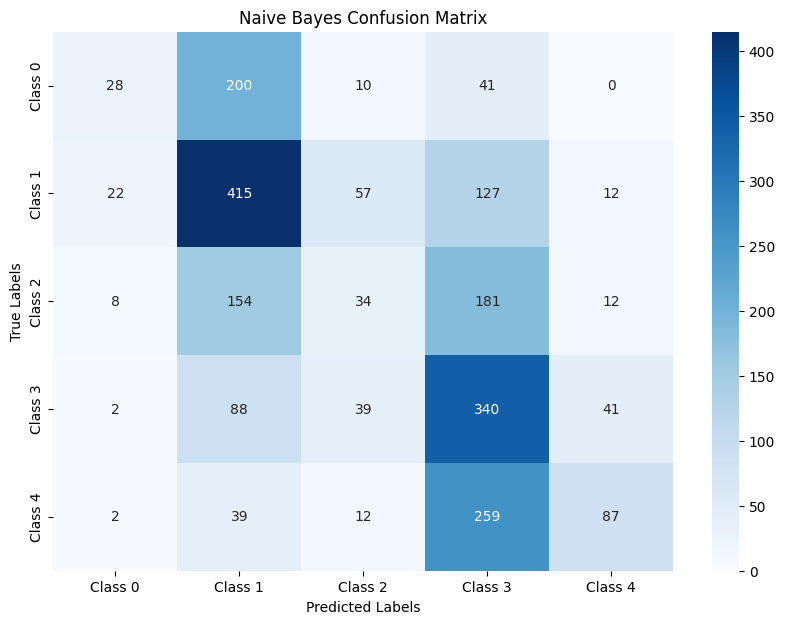

Naive Bayes Precision: [0.4516129  0.46316964 0.22368421 0.35864979 0.57236842]
Naive Bayes Recall: [0.10035842 0.65560821 0.0874036  0.66666667 0.21804511]
Naive Bayes F1 Score: [0.16422287 0.54283846 0.12569316 0.46639232 0.31578947]


In [ ]:
# Generate confusion matrix
naive_bayes_cm = confusion_matrix(test_labels, sklearn_nb_predictions)

# Compute precision, recall, and F1 score
precision_naive_bayes, recall_naive_bayes, f1_score_naive_bayes = precision_recall_f1(naive_bayes_cm)
print(naive_bayes_cm)
# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(naive_bayes_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

# Print precision, recall, and F1 score
print("Naive Bayes Precision:", precision_naive_bayes)
print("Naive Bayes Recall:", recall_naive_bayes)
print("Naive Bayes F1 Score:", f1_score_naive_bayes)
